# Scanner to svg

To gnerate a svg from any scan via png.

You need to specify the filename of the scan first.

Then you will get 3 different approchaes, choose the one, you like most.

You need to specify your dpi (dots per inch) of the scan. If you don't know it, you can use the default value of 300 dpi.

The svg will be saved with the same name (but with .svg) in a folder svg/.

# Attention: 
set the right scaling factor for your scan. 

'''inkscape_factor''' is the variable, you need to change. The only way i know to get this factor is by go into inkscape, after you run the script and check in the document properties the `Scale`.

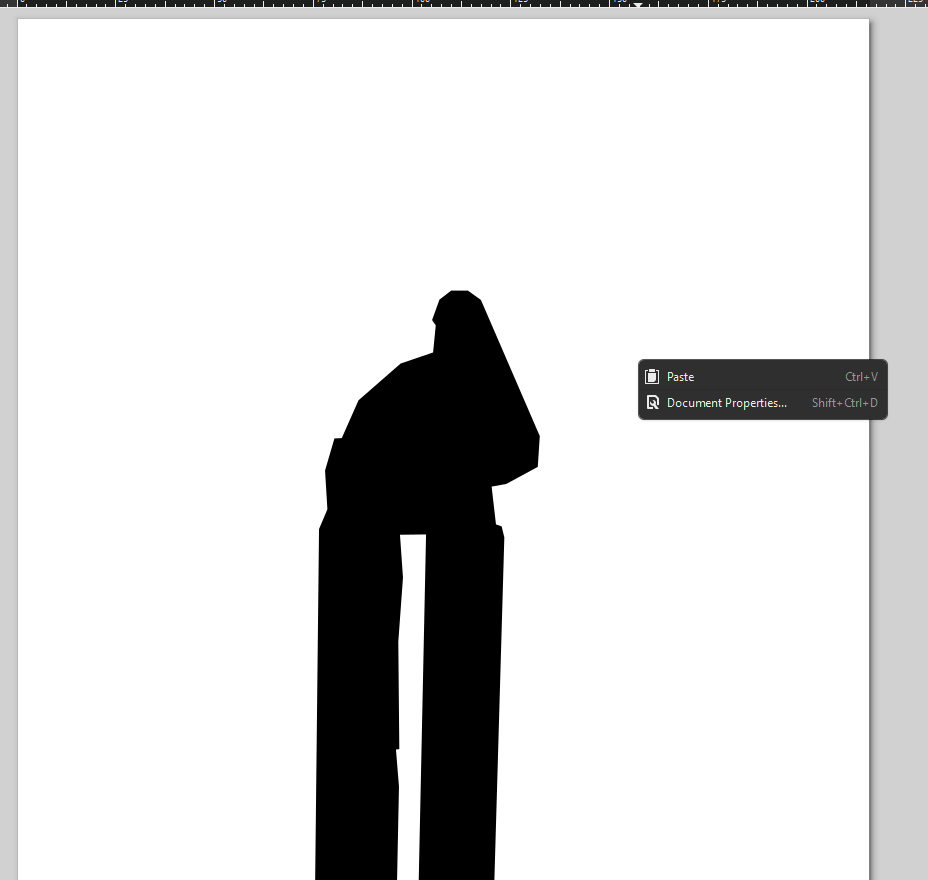 

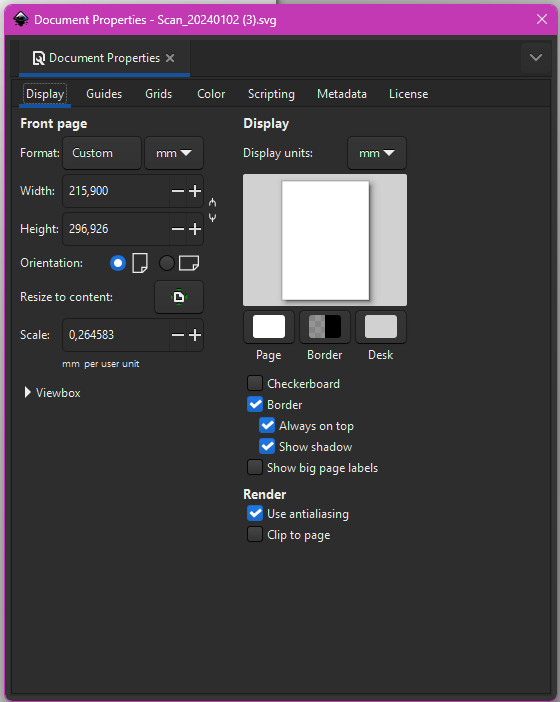

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# 1. Get the scan and make it black and white

## 1.1. Set the filename of the scan

In [2]:
file_name = ''

## 1.2. Convert to Grayscale

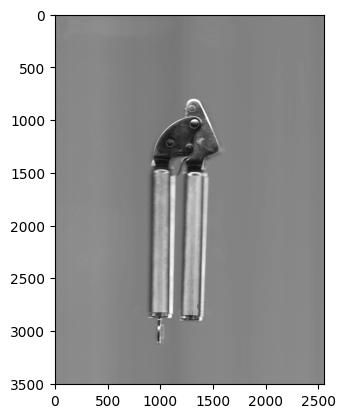

In [3]:
rgb_img = cv2.imread(file_name)
gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)
height, width = gray_img.shape

plt.imshow(gray_img,cmap="gray")

## 1.3. make the background black and the item white

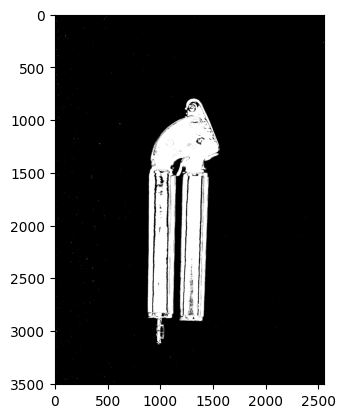

In [12]:
binary_img = gray_img.copy()
# get the gray value of the backgroud
gray_value = np.median(binary_img)

# set everything, thats not nearly backgorund-gray to white
threshold = 20
binary_img[binary_img > gray_value + threshold] = 255
binary_img[binary_img < gray_value - threshold] = 255

# everything that is not white, make it black
binary_img[binary_img < 255] = 0

# convert to binary

_, binary_img = cv2.threshold(binary_img, 150, 255, cv2.THRESH_BINARY)

plt.imshow(binary_img,cmap="gray")

# 2. Preprocessing with different methods

# 2.1. get rid of the withe noise in the background

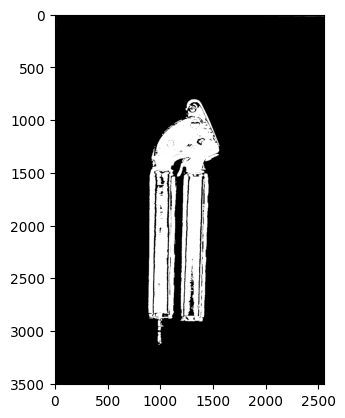

In [5]:
kernel = np.ones((2, 2), np.uint8) 
opening = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel, iterations=5)
plt.imshow(opening,cmap="gray")

## 2.2. get rid of some holes (mostly from reflections) in the image

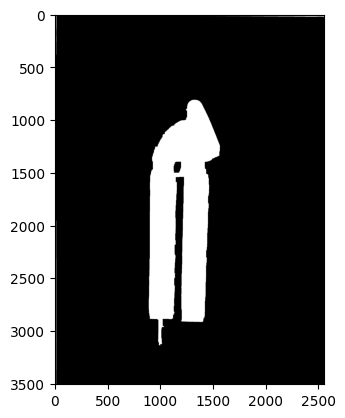

In [6]:
kernel = np.ones((10, 10), np.uint8) 
closing_with_opening = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=5) 

plt.imshow(closing_with_opening,cmap="gray")

## 2.3. get rid of some holes (mostly from reflections) in the image, now without using the opening beforehand.

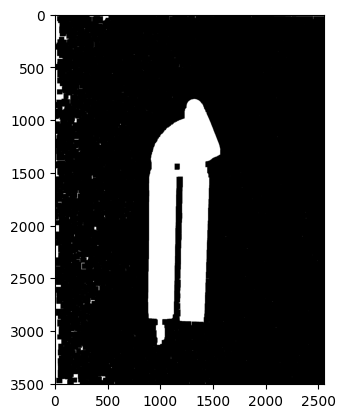

In [7]:
kernel = np.ones((10, 10), np.uint8) 
closing_only = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel, iterations=5) 

plt.imshow(closing_only,cmap="gray")

# 3. Calculate and display the contours.

In [8]:
def get_contours(img, ax, name = "img", smoothing_factor = 0):
      
   contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

   # sort contours by area, descending
   contours = sorted(contours, key=cv2.contourArea, reverse=True)
   
   peri = cv2.arcLength(contours[0], True)
   contours[0] = cv2.approxPolyDP(contours[0], smoothing_factor * peri, True)                   
   # draw contours on the original image
   image_copy = rgb_img.copy()
   cv2.drawContours(image=image_copy, contours=contours[:1], contourIdx=-1, color=(0, 255, 0), thickness=10, lineType=cv2.LINE_AA)
      
   # see the results
   ax.imshow(image_copy)
   ax.set_title(f'Contour of {name}')
   
   return contours[0]

## 3.1. Generate contours for all preprocessed images

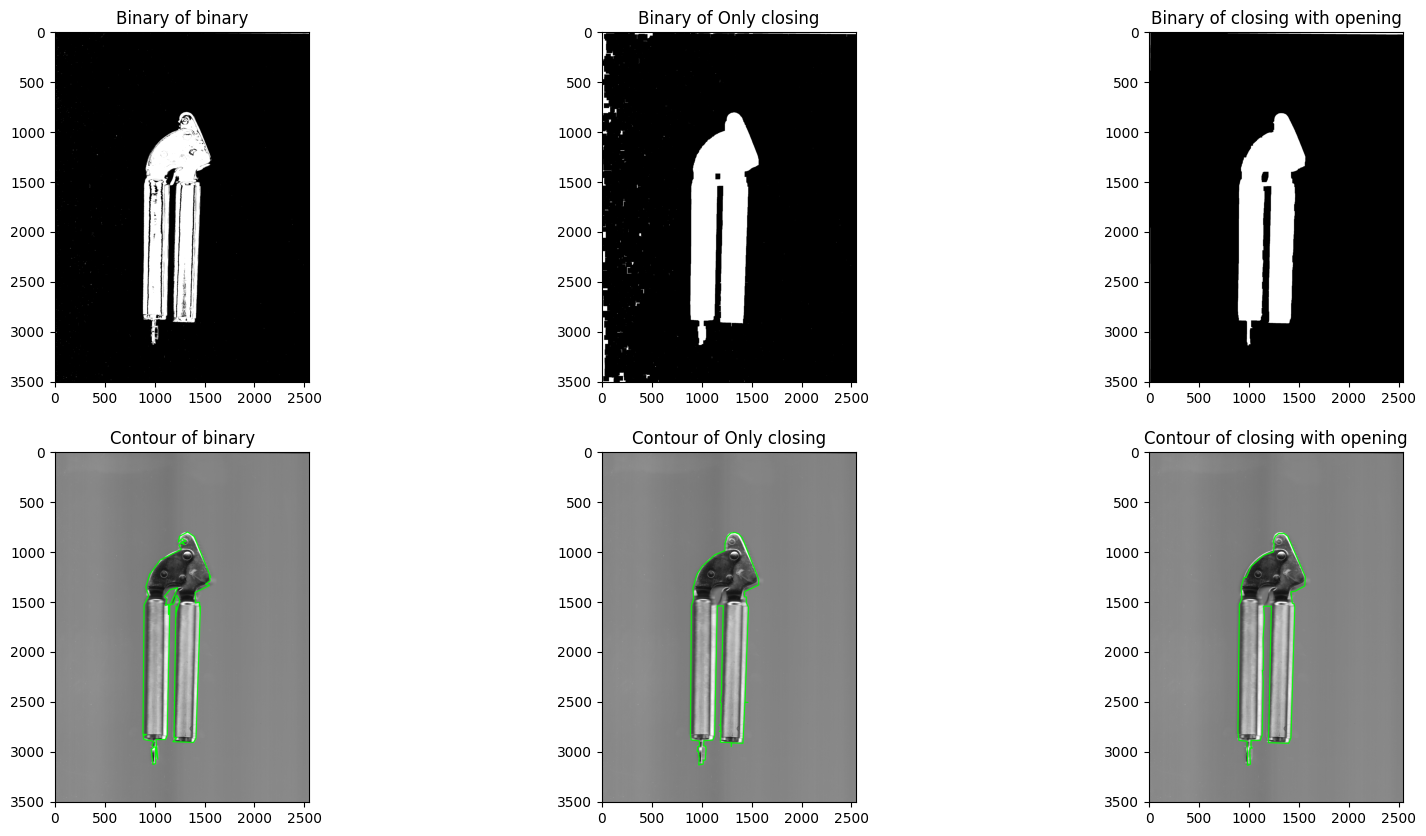

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

all_imgs = [binary_img, closing_only , closing_with_opening]
all_names = ["binary", "Only closing", "closing with opening"]

all_contours = []

for ax, img, name in zip(axes.transpose(), all_imgs, all_names):
   ax[0].imshow(img, cmap="gray")
   ax[0].set_title(f'Binary of {name}')
   all_contours.append(get_contours(img, ax[1], name, 0.001))
   

# 4 Export the contour

## 4.1. choose a contour [0, 1, 2] and convert pixel to mm, via dpi.

Attention: set the right dpi from your scan and the skaling factor for your computer.

In [10]:
best_contour = all_contours[2].copy() # edit here to change the contour
dpi = 300 # edit here to change the dpi

# inkscape factor, open your svg in inkscape, open documentsettings and look at the scaling factor 
# TODO: get this factor automatically
inkscape_factor = 0.264583 # edit here to change the inkscape factor

# ______________________________________________________________________________________________________________________
# to get the right size, we need to convert the pixels to mm
Inch = 25.4

conv = Inch/dpi

width_mm = width * conv
height_mm = height * conv

conv_with_inkscape_factor = conv/inkscape_factor

## 4.2. Save the choosen contoure as svg.

In [11]:
svg_file_name = file_name.split('.')[0]
svg_file_name = svg_file_name.split('/')[-1]
svg_file_name = f'svg/{svg_file_name}.svg'

unit = "mm"

os.makedirs("svg", exist_ok=True)

with open(svg_file_name, 'w+') as f:
    f.write(f'<svg width="{width_mm}{unit}" height="{height_mm}{unit}" xmlns="http://www.w3.org/2000/svg" viewBox="0 0 {width_mm}{unit} {height_mm}{unit}">')
    f.write(f'<g transform="scale({conv_with_inkscape_factor})">')
    f.write('<path d="M')

    for point in best_contour:
        x, y = point[0]
        f.write(f'{x} {y} ')

    # close the path
    x, y = best_contour[0][0]
    f.write(f'{x} {y}" />')

    f.write('</g>')
    f.write('</svg>')
    f.close()
